# Data Cleaning
Perform the following steps on the `comment_text` column:
- Convert to lower case
- Remove any URLs
- Strip any extra whitespace

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os, re, math, string, random, warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
for res in ['punkt','punkt_tab','stopwords','vader_lexicon']:
    nltk.download(res)
from nltk.sentiment import SentimentIntensityAnalyzer 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\celin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# import file
df = pd.read_csv(r"C:\Users\celin\OneDrive\Education\USD-MS-ADS\ADS-509-Applied-Text-Mining\Final-Project\ADS-509_LLM\data\bluesky_comments.csv")

In [4]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
def normalize_text(s):
    if not isinstance(s, str):
        return ''
    # TODO: convert text to lowercase, remove URLs from the text using the regex from above, and remove extra white space
    s = s.lower() # lowercase
    s = URL_RE.sub(' ', s) # remove URLs
    s = re.sub(r'\s+',' ',s).strip() # remove extra white space
    return s

df['text_norm'] = df['comment_text'].apply(normalize_text)
df[['comment_text','text_norm']].head(3)

,comment_text,text_norm
0,CW: politics\r\n\r\ni really think people unde...,cw: politics i really think people underrate h...
1,"""Racist Pig” indeed, says it all‼️","""racist pig” indeed, says it all‼️"
2,"So, if they block the names of recipients and ...","so, if they block the names of recipients and ..."


# Tokenization
- Build a tokenizer use the `nltk.word_tokenize` function that returns a list of individual words.
- Use the regex provided to build a tokenizer function that returns a list of individual words.

In [5]:
# NLTK tokenizer
def tokenize_nltk(s):
    # use the nltk.word_tokenize function to produce a list of tokens
    return [t for t in word_tokenize(s) if t.strip()] # logic to make sure that string has non-white space

# Regex fallback (keeps alphanumerics and simple contractions)
TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?")
def tokenize_regex(s):
    # TODO: use the regex provided to produce a list of tokens
    return TOKEN_RE.findall(s)

# Choose tokenizer (easy to switch for demos)
df['nltk'] = df['text_norm'].apply(tokenize_nltk)
df['regex'] = df['text_norm'].apply(tokenize_regex)
df['nltk_n'] = df['nltk'].apply(len)
df['regex_n'] = df['regex'].apply(len)
df[['text_norm','nltk', 'nltk_n', 'regex', 'regex_n']].head(3)

,text_norm,nltk,nltk_n,regex,regex_n
0,cw: politics i really think people underrate h...,"[cw, :, politics, i, really, think, people, un...",46,"[cw, politics, i, really, think, people, under...",41
1,"""racist pig” indeed, says it all‼️","[``, racist, pig, ”, indeed, ,, says, it, all‼️]",9,"[racist, pig, indeed, says, it, all]",6
2,"so, if they block the names of recipients and ...","[so, ,, if, they, block, the, names, of, recip...",36,"[so, if, they, block, the, names, of, recipien...",31


In [6]:
df['nltk'] = df['text_norm'].apply(tokenize_nltk)
df['nltk']

0        [cw, :, politics, i, really, think, people, un...
1         [``, racist, pig, ”, indeed, ,, says, it, all‼️]
2        [so, ,, if, they, block, the, names, of, recip...
3        [given, the, rococo, decor, of, his, ny, condo...
4        [btw, i, 've, seen, pictures, of, the, youthfu...
                               ...                        
11285                [alex, never, really, left, guido, .]
11286    [there, you, go, then, nothing, like, confiden...
11287             [has, camilla, tominey, transitioned, ?]
11288    [optimistic, to, the, point, of, delusional, ....
11289                              [they, are, deluded, .]
Name: nltk, Length: 11290, dtype: object

In [7]:
df['regex'] = df['text_norm'].apply(tokenize_regex)
df['regex']

0        [cw, politics, i, really, think, people, under...
1                     [racist, pig, indeed, says, it, all]
2        [so, if, they, block, the, names, of, recipien...
3        [given, the, rococo, decor, of, his, ny, condo...
4        [btw, i've, seen, pictures, of, the, youthful,...
                               ...                        
11285                   [alex, never, really, left, guido]
11286    [there, you, go, then, nothing, like, confiden...
11287                [has, camilla, tominey, transitioned]
11288    [optimistic, to, the, point, of, delusional, v...
11289                                 [they, are, deluded]
Name: regex, Length: 11290, dtype: object

## Stop Words and Punctuation Filtering
Build a function that will take our list of individual tokens as input to:
- Remove all punctuation
- Remove all stop words
- Remove all numeric tokens (This does not mean removing all digits from the tokens, but removing tokens that are standalone numbers)

In [8]:
EN_STOP = set(stopwords.words('english'))
CUSTOM_STOP = set(['nt', 'like', 'also', 'would', 'could', 'even', 'much']) # TODO: update this list as desired to get a more meaningful list of top words
PUNCT = set(string.punctuation)
ALL_STOP = EN_STOP | CUSTOM_STOP | PUNCT

def filter_tokens(tokens, drop_numbers=True):
    out = []
    for tok in tokens:
        # TODO: remove all punctuation, stop words, and numeric tokens from the list of tokens
        if tok not in ALL_STOP: # OpenAI. (2023). ChatGPT (May 3 version) [Large language model]. https://chat.openai.com/chat. 
            out.append(tok)
    return out

df['tokens_clean'] = df['nltk'].apply(filter_tokens)
df['n_tokens_clean'] = df['tokens_clean'].apply(len)
df[['nltk','tokens_clean','nltk_n','n_tokens_clean']].head(3)

,nltk,tokens_clean,nltk_n,n_tokens_clean
0,"[cw, :, politics, i, really, think, people, un...","[cw, politics, really, think, people, underrat...",46,25
1,"[``, racist, pig, ”, indeed, ,, says, it, all‼️]","[``, racist, pig, ”, indeed, says, all‼️]",9,7
2,"[so, ,, if, they, block, the, names, of, recip...","[block, names, recipients, namesake, dead, for...",36,17


## N-grams and Visualizations

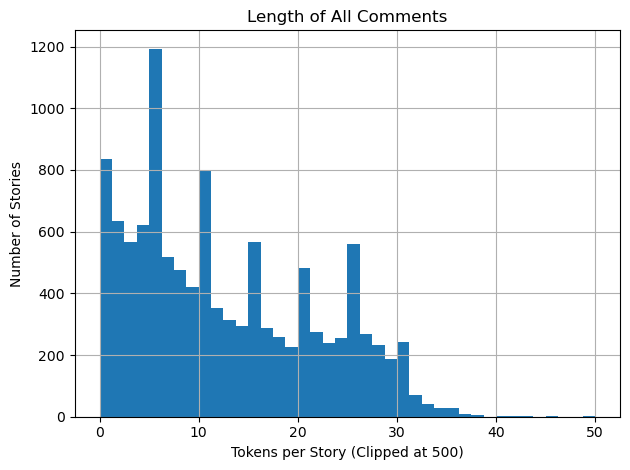

In [9]:
# TODO: Fill in the blanks to build a histogram of the n_tokens_clean column
ax = df['n_tokens_clean'].clip(upper=500).hist(bins=40)
ax.set_xlabel('Tokens per Story (Clipped at 500)')
ax.set_ylabel('Number of Stories')
ax.set_title('Length of All Comments')
plt.tight_layout()
plt.show()

In [10]:
# Most common cleaned unigrams
all_toks = [t for row in df['tokens_clean'] for t in row]
cnt = Counter(all_toks)
top_cnt = pd.DataFrame(cnt.most_common(30), columns=['token','count'])
top_cnt.head(10)

,token,count
0,’,3036
1,'s,1970
2,n't,1502
3,people,1145
4,``,979
5,'',958
6,think,740
7,...,696
8,one,648
9,“,633


In [11]:
# Most common bi-grams
def bigrams(lst):
    return list(zip(lst, lst[1:])) if len(lst) > 1 else []
all_bi = []
for row in df['tokens_clean']:
    all_bi.extend(bigrams(row))
bi_cnt = Counter(all_bi)
top_bi = pd.DataFrame([(f"{a} {b}", c) for (a,b), c in bi_cnt.most_common(30)], columns=['bigram','count'])
top_bi.head(10)

,bigram,count
0,ca n't,179
1,concentration camps,101
2,wo n't,77
3,n't think,68
4,right wing,65
5,n't know,64
6,think ’,61
7,gon na,52
8,think 's,52
9,social media,46


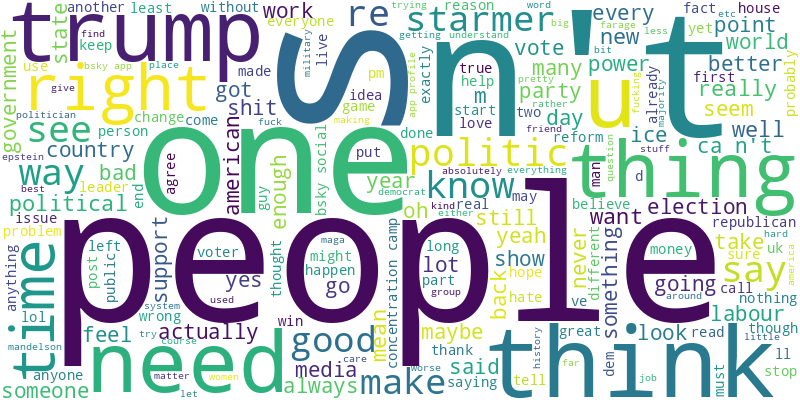

In [12]:
# Visualize with a wordcloud
wc = WordCloud(width=800, height=400, background_color='white')
text_blob = ' '.join(all_toks[:200000])  # cap for speed
img = wc.generate(text_blob).to_image()
display(img)

# Vectorization

In [13]:
# Use the CountVectorizer function to create a TF document-term matrix with the settings described above.
cv = CountVectorizer(lowercase=True, stop_words='english', max_df=0.95, min_df=5) # scikit-learn developers. (n.d.). Countvectorizer. scikit-learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
X_tf = cv.fit_transform(df['text_norm'].fillna(''))
vocab = np.array(cv.get_feature_names_out())
X_tf.shape, len(vocab)

((11290, 4252), 4252)

In [14]:
# Use the TfidfVectorizer function to create a TF-IDF document-term matrix with the settings described above.
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', max_df=0.95, min_df=5)
X_tfidf = tfidf.fit_transform(df['text_norm'].fillna(''))
tfidf_vocab = np.array(tfidf.get_feature_names_out())
X_tfidf.shape, len(tfidf_vocab)

((11290, 4252), 4252)

In [15]:
# Compare top tf anf tf-idf terms for a given doc
def top_terms(row_vector, vocab, k=10):
    row = row_vector.toarray().ravel()
    idx = row.argsort()[::-1][:k]
    return list(zip(vocab[idx], row[idx]))

# Show top terms for 3 random comments
for i in np.random.choice(X_tfidf.shape[0], size=3, replace=False):
    print(f"Doc {i} → top terms:")
    print("TF:")
    print(top_terms(X_tf[i], tfidf_vocab, k=10))
    print("TF-IDF:")
    print(top_terms(X_tfidf[i], tfidf_vocab, k=10))
    print('-'*60)

Doc 1451 → top terms:
TF:
[('useless', np.int64(2)), ('people', np.int64(1)), ('stupid', np.int64(1)), ('known', np.int64(1)), ('make', np.int64(1)), ('live', np.int64(1)), ('thing', np.int64(1)), ('just', np.int64(1)), ('hateful', np.int64(1)), ('country', np.int64(1))]
TF-IDF:
[('useless', np.float64(0.657974193142262)), ('hateful', np.float64(0.3561135363109672)), ('known', np.float64(0.27970200345281365)), ('stupid', np.float64(0.2625120505318671)), ('live', np.float64(0.25071858400536406)), ('absolutely', np.float64(0.2434015669624823)), ('country', np.float64(0.2079261934012599)), ('thing', np.float64(0.20689459502735388)), ('make', np.float64(0.20393999425407489)), ('people', np.float64(0.14736997931808798))]
------------------------------------------------------------
Doc 2301 → top terms:
TF:
[('000', np.int64(0)), ('zoning', np.int64(0)), ('zone', np.int64(0)), ('zionist', np.int64(0)), ('zero', np.int64(0)), ('yuri', np.int64(0)), ('yup', np.int64(0)), ('yr', np.int64(0)), (

# Sentiment Analysis

In [16]:
# Use the VADER sentiment lexicon to score our dataset
sia = SentimentIntensityAnalyzer()
scores = df['text_norm'].fillna('').apply(sia.polarity_scores)
df['sent_compound'] = scores.apply(lambda d: d['compound'])

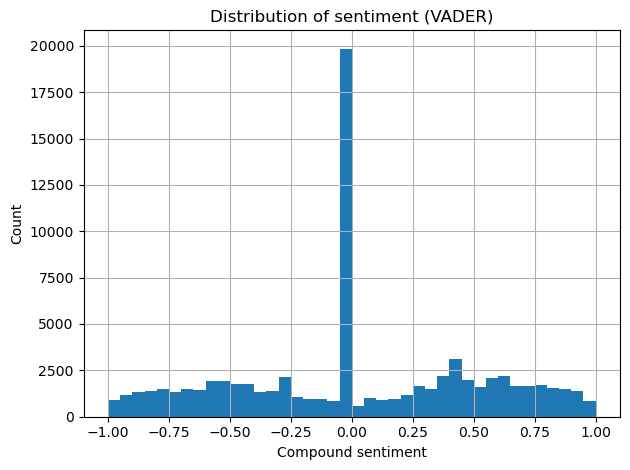

In [37]:
# Sentiment distribution
ax = df['sent_compound'].hist(bins=40)
ax.set_xlabel('Compound sentiment')
ax.set_ylabel('Count')
ax.set_title('Distribution of sentiment (VADER)')
plt.tight_layout()
plt.show()